In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

import math
import random
import shutil

from PIL import Image
from pathlib import Path
from joblib import delayed, Parallel
from typing import List
from tqdm.notebook import tqdm

## Downloading ImageNet Dataset

A subset of the ImageNet dataset is used to train the classifier. If you would like to train your own algorithm. Follow these steps and prepare the dataset. 

1. The original dataset with additional labels for object detection is semi-publicly available at [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/data). To download the dataset you need to register a Kaggle account and join the challenge.

2. Download the data via the `kaggle-api` (see guidelines [here](https://github.com/Kaggle/kaggle-api#api-credentials)) or use the `Download All` button.

3. After the download is complete extract and unuzip the files in a directory of your choice. 

4. If you want to train a cat classifier, create a new virtual environment and install the `requirements.txt` file, e.g. with 

```
pip install -r requirements.txt 
```

In [5]:
# specify the image directory according to your downloaded version of the ImageNet
root = Path('path/to/your/ImageNet/ILSVRC/Data/CLS-LOC/')
train_dir = root / 'train'
valid_dir = root / 'val'
test_dir = root / 'test'

# link between ids and labels
class_map = 'imagenet_info/LOC_synset_mapping.txt'

### Create helper dicts

In [6]:
# read class map
wnid_to_label = dict()
with open(class_map) as file:
    for line in file:
        annotations = line.rstrip().split(',')[0]
        syn_id, label = annotations[:9], annotations[10:]
        wnid_to_label[syn_id] = label.lower()

# save dict to pickle file
with open('imagenet_info/wnid_to_label.pkl', 'wb') as file:
    pickle.dump(wnid_to_label, file)

# wnid_to_label

In [5]:
# create inverse class dict
label_to_wnid = {v: k for k, v in wnid_to_label.items()}
# label_to_wnid

In [6]:
label_to_wnid['cougar']

'n02125311'

In [7]:
label_to_wnid['lynx']

'n02127052'

In [8]:
# create helpers 
class_to_label = {
    0: ['egyptian cat', 'persian cat', 'siamese cat', 'tabby'], 
    1: ['cougar', 'lynx', 'cheetah'], 
    2: ['jaguar', 'leopard', 'lion', 'snow leopard', 'tiger']
    }
class_to_newlabel = {
    0: 'domestic cat',
    1: 'wild cat',
    2: 'big cat'
}

class_to_wnid = {cls: [label_to_wnid[lbl] for lbl in labels] for cls, labels in class_to_label.items()}
label_to_class = {cls: lbl for lbl, classes in class_to_label.items() for cls in classes}
wnid_to_class = {label_to_wnid[lbl]: cls for lbl, cls in label_to_class.items()}


# save dict to pickle file
with open('wnid_to_class.pkl', 'wb') as file:
    pickle.dump(wnid_to_class, file)


# save dict to pickle file
with open('class_to_label.pkl', 'wb') as file:
    pickle.dump(class_to_newlabel, file)

In [9]:
cat_classes = list(wnid_to_class.keys())
# cat_classes

### Create new cat directory and split images to train, val, test sets


In [10]:
# make new cat dir 
cat_dir = Path('Cats')
cat_dir.mkdir(exist_ok=True)

# create train, val, test splits
cat_train = cat_dir / 'train'
cat_val = cat_dir / 'val'
cat_test = cat_dir / 'test'

In [11]:
def copy_image_list(image_list: List[Path], dst_dir: Path) -> None:
    """Copy list of images using multiprocessing.

    Args:
        image_list (List[Path]): List of path/to/image to copy.
        dst_dir (Path): Destination directory.
    """
    Parallel(n_jobs=8)(delayed(_copy_image)(img, dst_dir) for img in image_list)
    

def _copy_image(src: Path, dst_dir: Path) -> None:
    """Copy image to destination directory.

    Args:
        src (Path): Path/to/image to copy.
        dst_dir (Path): Destination directory.
    """
    parent = src.parts[-2]
    name = src.name
    class_dir = dst_dir / parent
    class_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(src, class_dir / name)
    

In [13]:
split_size = [0.6, 0.2]
seed = 42

# split each category to train/val/test sets
for cat in tqdm(cat_classes):

    images = list(train_dir.joinpath(cat).glob('*.JPEG'))
    N = len(images)

    train_size, val_size= int(N * split_size[0]), int(N * sum(split_size))

    random.seed(seed)
    random.shuffle(images)

    train_images = images[:train_size]
    val_images = images[train_size:val_size]
    test_images = images[val_size:]

    copy_image_list(train_images, cat_train)
    copy_image_list(val_images, cat_val)
    copy_image_list(test_images, cat_test)

    print(f'{wnid_to_label[cat]}: train {len(train_images)}, val {len(val_images)}, test {len(test_images)}')

  0%|          | 0/12 [00:00<?, ?it/s]

egyptian cat: train 780, val 260, test 260
persian cat: train 780, val 260, test 260
siamese cat: train 780, val 260, test 260
tabby: train 780, val 260, test 260
cougar: train 780, val 260, test 260
lynx: train 780, val 260, test 260
cheetah: train 780, val 260, test 260
jaguar: train 780, val 260, test 260
leopard: train 780, val 260, test 260
lion: train 780, val 260, test 260
snow leopard: train 780, val 260, test 260
tiger: train 780, val 260, test 260


In [10]:
def load_img(path: Path) -> Image.Image:
    """Load image from path."""
    with open(path, 'rb') as file:
        img = Image.open(file)
        img = img.resize((224, 224))
        return img

def show_imgs(files, savename=None):
    fig, ax = plt.subplots(len(files), 1, figsize=(4, 12))
    for i, file in enumerate(files):
        img = load_img(file)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

In [32]:
[wnid_to_label[wnid] for wnid in cat_classes]

['egyptian cat',
 'persian cat',
 'siamese cat',
 'tabby',
 'cougar',
 'lynx',
 'cheetah',
 'jaguar',
 'leopard',
 'lion',
 'snow leopard',
 'tiger']

In [12]:
presentation_dir = Path('presentation')
num_images = 5

fig, ax = plt.subplots(num_images, len(cat_classes), figsize=(25, 11))
for cat_idx, cat in enumerate(cat_classes):
    images = list(train_dir.joinpath(cat).glob('*.JPEG'))
    samples = random.sample(images, num_images)
    for img_idx, img in enumerate(samples):
        ax[img_idx, cat_idx].imshow(load_img(img))
        ax[img_idx, cat_idx].axis('off')
plt.tight_layout()
plt.savefig(presentation_dir / 'imagenet_cats.png', bbox_inches='tight')
plt.show()

### Load datamodule

In [21]:
from lib.utils import UnNormalizer

UnNormalizer = UnNormalizer()

def show_image(img, target=None):
    img = UnNormalizer(img).permute(1, 2, 0)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    if target is not None:
        plt.title(target.item())
    plt.show()


def show_batch(batch, nrows=4, ncols=4, figsize=(8,8), savename=None):
    images, targets = batch
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        # ax.imshow(UnNormalizer(images[i].permute(1,2,0)))
        ax.imshow(images[i].permute(1,2,0) / 255.)
        ax.axis('off')
        ax.set_title(targets[i].item())
    plt.tight_layout()
    if savename:
        plt.savefig(savename, dpi=150, bbox_inches='tight')
    plt.show()

In [22]:
from lib.datamodule import ImageNetModule


# set dirs
plot_dir = './figures/'

# load helper
wnid_to_class = pickle.load(open('imagenet_info/wnid_to_class.pkl', 'rb'))
class_to_label = pickle.load(open('imagenet_info/class_to_label.pkl', 'rb'))

# load data module
dm = ImageNetModule(
    img_dir=cat_dir, 
    wnid_to_class=wnid_to_class, 
    class_to_label=class_to_label,
    pilot_data=True,
    batch_size=16
    )

In [23]:
dm.setup('fit')
dm.setup('test')

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

/old_home/ammeling/projects/ImageNet/.env/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


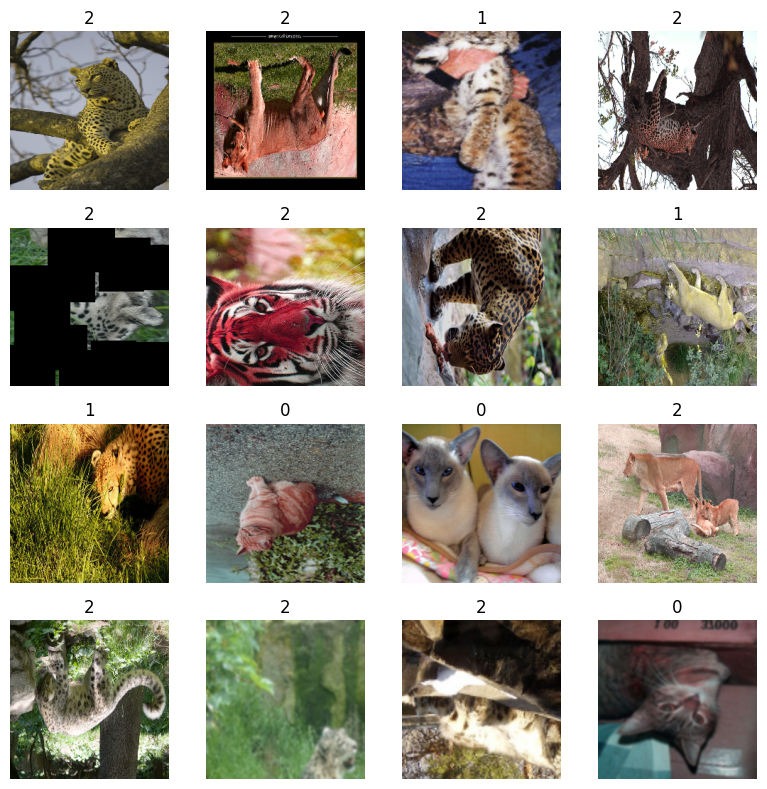

In [27]:
batch = next(iter(train_loader))
show_batch(batch, nrows=4, ncols=4, savename=os.path.join(plot_dir, 'train_batch_03.png'))

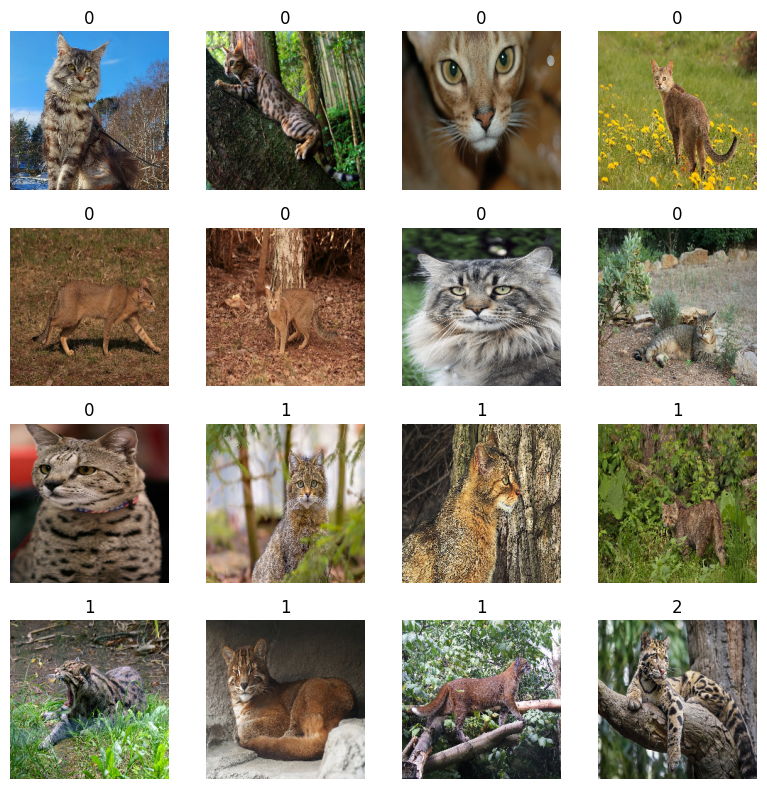

In [29]:
val_iter = iter(val_loader)
batch = next(val_iter)
show_batch(batch, nrows=4, ncols=4, savename=os.path.join(plot_dir, 'val_batch_01.png'))